# Model training

## Import libraries

The following command must be executed for balancing:

```conda install -c conda-forge imbalanced-learn```

In [1]:
from enum import Enum
import math
import win32com.client as win32

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_curve, fbeta_score, make_scorer
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from scipy import stats
from imblearn.over_sampling import RandomOverSampler

In [2]:
# Tensorflow may not be installed on every system
import tensorflow as tf
from scikeras.wrappers import KerasClassifier

## Methods

In [3]:
def truncate(number, digits) -> float:
    # Helper method that truncate scores to four decimals
    nbDecimals = len(str(number).split('.')[1])
    if nbDecimals <= digits:
        return number
    stepper = 10.0 ** digits
    return math.trunc(stepper * number) / stepper


def get_nested(data, *args):
    # Helper method that returns the value of a nested dictionary
    if args and data:
        element  = args[0]
        if element:
            value = data.get(element)
            return value if len(args) == 1 else get_nested(value, *args[1:])
    return None


def get_scores(y_test, y_predicted):
    # Method that returns different scores for the passed parameters
    digits = 4
    scores = {
        'Accuracy': truncate(accuracy_score(y_test, y_predicted), digits),
        'Recall': truncate(recall_score(y_test, y_predicted), digits),
        'Precision': truncate(precision_score(y_test, y_predicted), digits),
        'F1 score': truncate(f1_score(y_test, y_predicted), digits),
        'F2 score': truncate(fbeta_score(y_test, y_predicted, beta=2), digits)
    }
    return scores


def print_scores(all_scores):
    # Method that prints a table of the passed scores
    header_row = "{header:<20}".format(header="Estimator")
    for score in list(all_scores.values())[0]:
        header_row+="{header:>15}".format(header=score)
    print(header_row,"\n")

    for estimator in all_scores.keys():
        current_row = "{estimator:<20}".format(estimator=estimator)
        estimator_scores = all_scores.get(estimator)
        for score in estimator_scores:
            score_value = get_nested(all_scores, estimator, score)
            current_row+="{score_value:>15}".format(score_value=score_value)
        print(current_row)
        

def print_best_params(estimator_params):
    # Method that prints the best parameters
    for estimator in estimator_params.keys():
        print("Best parameters for "+estimator+": ")
        parameters = estimator_params.get(estimator)
        for parameter in parameters:
            print(parameter+": "+str(get_nested(estimator_params, estimator, parameter)))
            

def plot_roc(title, ax, y_test, y_predicted):
    # Method that plots the ROC for the passed parameters
    false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_predicted)
    ax.plot(false_positive_rate, true_positive_rate)
    ax.plot([0, 1], ls="--")
    ax.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")

    ax.set_title('Receiver Operating Characteristic (ROC) - '+title)
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
    

def plot_feature_importance(title, ax, estimator, X_train):
    # Method that plots the feature importance for the passed parameters
    feat_importance = pd.Series(estimator.feature_importances_, index=X_train.columns)
    feat_importance.nlargest(12).plot(kind='barh', ax=ax)

    ax.set_title('Feature Importance for '+title)


def plot_learning_curve(title, estimator, ax, X, y, cv, scoring=None):
    # Method that plots the learning curve for the passed parameters
    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        scoring=scoring,
        cv=cv,
        n_jobs=4,
        train_sizes=np.linspace(0.1, 1.0, 5),
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    ax.grid()
    ax.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    ax.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    ax.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    ax.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")

    ax.set_title("Learning Curve: "+title)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    ax.legend()
    
    
def plot_loss(title, history):
    # list all data in history
    print(history.history.keys())
    # summarize history for recall
    for metric in history.history.keys():
        if not str(metric).startswith("val"):
            plt.plot(history.history[metric])
            plt.plot(history.history['val_'+metric])
            plt.title(title + 'model ' + metric)
            plt.ylabel(metric)
            plt.xlabel('epoch')
            plt.legend(['train', 'validation'], loc='upper left')
            plt.show()


def send_mail_via_outlook(message:str):
    mail = outlook.CreateItem(0)
    mail.To = 'abc@random insert mail address.de'
    mail.Subject = 'Estimator done!'
    mail.Body = message
    #mail.HTMLBody = '<h2>HTML Message body</h2>' #this field is optional
    # To attach a file to the email (optional):
    # attachment  = "Path to the attachment"
    # mail.Attachments.Add(attachment)
    mail.Send()
        

def model_evaluate(estimator, parameters, X_train, X_test, y_train, y_test, cv_folds=2, n_jobs=-1, do_send_notification_mail=False):
    # Method that trains the passed model with the passed parameters and plots the evaluation of it
    scoring = make_scorer(fbeta_score, beta=2)

    # create the grid search instance
    grid_search_estimator = GridSearchCV(estimator=estimator.value,
                                         param_grid=parameters,
                                         scoring= scoring,
                                         cv=cv_folds,
                                         return_train_score=True,
                                         verbose=3,
                                         n_jobs=n_jobs
                                         )
    # training and prediction
    fitted_estimator_grid = grid_search_estimator.fit(X_train, y_train)
    best_fitted_estimator = fitted_estimator_grid.best_estimator_
    y_predicted = fitted_estimator_grid.predict(X_test)
    
    # evaluation of the model
    print_scores({estimator.name: get_scores(y_test, y_predicted)})
    print_best_params({estimator.name: fitted_estimator_grid.best_params_})

    figure = plt.figure(figsize=(15, 15))
    figure_index = 1
    number_of_rows = 2
    number_of_columns = 2
    
    # plot roc
    ax = figure.add_subplot(number_of_rows, number_of_columns, figure_index)
    plot_roc(title=estimator.name, ax=ax, y_test=y_test, y_predicted=y_predicted)
    figure_index += 1
    
    # plot feature importance in case of forest estimator
    if estimator==Estimator.forest_estimator:
        ax = figure.add_subplot(number_of_rows, number_of_columns, figure_index)
        plot_feature_importance(title=estimator.name, ax=ax, estimator=fitted_estimator_grid.best_estimator_, X_train=X_train)
        figure_index += 1
        
    if estimator==Estimator.log_regr_estimator:
        headers = ["Coefficient", "value"]
        print_template = ""
        for i in range(len(headers)):
            k = len(headers[i])
            print_template += "{" + str(i) + ":" + str(k+5) + "}|"
        print(print_template.format(*headers))
        print(print_template.format("intercept", best_fitted_estimator.intercept_[0]))
        i = 0
        for coef in best_fitted_estimator.coef_[0]:
            feature_name = best_fitted_estimator.feature_names_in_[i]
            print(print_template.format(feature_name, round(coef, 5)))
            i += 1
    plt.show()
    
    if do_send_notification_mail:
        send_mail_via_outlook("The estimator {} was fitted with params: {}".format(estimator.name, fitted_estimator_grid.best_params_))
        
    return fitted_estimator_grid

## Setup data

Load preprocessed dataset and create objects X and y to store the data and the target value. Then split data into training data and testing data.

In [4]:
# choose parameters
use_reduced_ds = False
use_sample = False

# Load dataset
if use_reduced_ds:
    heart_dataset = pd.read_csv('./heart_dataset_preprocessed_reduced.csv')
else:
    heart_dataset = pd.read_csv('./heart_dataset_preprocessed.csv')
print(heart_dataset.columns)
if use_sample:
    sample_size = 3000
    selected_data = heart_dataset.sample(n=sample_size, random_state=3)
else:
    selected_data = heart_dataset

# Split and reduce dataset (reduction only for test purposes)
X = selected_data.drop(columns='HeartDisease')
y = selected_data['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify=y)

# Balance training data
X_train_oversampled, y_train_oversampled = RandomOverSampler().fit_resample(X_train, y_train)

data_dict = {"X_train": X_train, "X_test": X_test, "y_train": y_train, "y_test": y_test}
data_dict_oversampled = {"X_train": X_train_oversampled, "X_test": X_test, "y_train": y_train_oversampled, "y_test": y_test}

Index(['HeartDisease', 'BMI', 'Smoking', 'AlcoholDrinking', 'Stroke',
       'PhysicalHealth', 'MentalHealth', 'DiffWalking', 'Sex', 'AgeCategory',
       'Diabetic', 'PhysicalActivity', 'GenHealth', 'SleepTime', 'Asthma',
       'KidneyDisease', 'SkinCancer', 'Race_American Indian/Alaskan Native',
       'Race_Asian', 'Race_Black', 'Race_Hispanic', 'Race_Other',
       'Race_White'],
      dtype='object')


## Baseline

We define a baseline model as a reference to the actual model with DummyClassifier from Scikit-Learn. Because our data is very imbalanced, we are using the stratified strategy.

Estimator                  Accuracy         Recall      Precision       F1 score       F2 score 

Dummy Classifier             0.5003         0.4978         0.0853         0.1457         0.2531


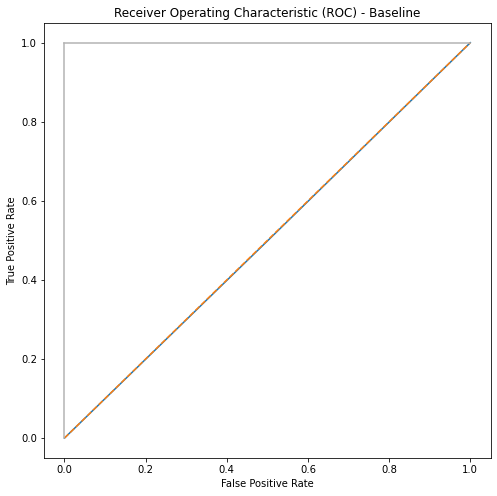

In [5]:
dummy_classifier = DummyClassifier(strategy='stratified')
dummy_classifier.fit(X_train_oversampled, y_train_oversampled)
y_predicted = dummy_classifier.predict(X_test)

print_scores({'Dummy Classifier':get_scores(y_test, y_predicted)})
plot_roc(title='Baseline', ax=plt.figure(figsize=(8, 8)).add_subplot(), y_test=y_test, y_predicted=y_predicted)
plt.show()

**Conclusion**

We achieve an 0.84 accuracy, a 0.09 recall, a 0.09 precision and a 0.09 F1-Score. Plotting the ROC curve shows that the baseline classifier is not really better than a random classifier


## Model selection

To find out which modeling method with which parameters best fits to our task, we define a set of modeling methods, train them with different parameters (hyperparameter tuning) and evaluate the results.

In [5]:
# Create DNN model
def create_model(dropout_rate, hidden_layer_sizes=(20, 20), activation='relu'):
    # create model
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape=(X_train.columns.size,)))
    
    for hidden_layer_size in hidden_layer_sizes:
        model.add(tf.keras.layers.Dense(hidden_layer_size, activation=activation))
    
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
              
    return model

# Enumeration class containing all estimators we want to consider for classification
class Estimator(Enum):
    knn_estimator=KNeighborsClassifier()
    forest_estimator=RandomForestClassifier(random_state=42)
    svc_estimator=SVC(random_state=42)
    log_regr_estimator=LogisticRegression(random_state=42)
    dnn_estimator=KerasClassifier(model=create_model, verbose=0, hidden_layer_sizes=(30, 30), activation='sigmoid', dropout_rate=0.0)
    xgb_estimator=GradientBoostingClassifier(random_state=42)

# Class Weights calculation
neg, pos = np.bincount(y_train)
total = neg + pos

weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

# Dictionary of parameter grids of the estimators
weights_ls = [{0:1, 1:1}, {0:1, 1:4}, {0: weight_for_0, 1: weight_for_1}]
n_estimators_ls_tree_models = [50, 100, 200, 800, 1000]
max_features_ls_tree_models = ['sqrt', 'log2']
validation_fraction_tree_models = [0.3]
n_iter_no_change_tree_models = [50]

param_grids = {
    Estimator.knn_estimator: {
        'n_neighbors': [2, 3, 4, 5]
    },
    Estimator.forest_estimator: {
        'class_weight': weights_ls,
        'n_estimators': n_estimators_ls_tree_models, 
        'max_features': max_features_ls_tree_models,
        'min_samples_split': [10],
        'max_samples': [1000, None],
        'n_jobs': [-1]
    },
    Estimator.svc_estimator: {
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'class_weight': weights_ls
    },
    Estimator.dnn_estimator: {
        'batch_size': [1000],
        'epochs': [100, 300],
        'hidden_layer_sizes': [(20,20), (60,30), (40,20,10)],
        'activation': ['relu'],
        'loss': ['binary_crossentropy'],
        'optimizer': ['SGD', 'adam'],
        'class_weight': weights_ls,
        'dropout_rate': [0.4]
    },
    Estimator.xgb_estimator: {
        'n_estimators': n_estimators_ls_tree_models,
        'loss': ['log_loss'], # like advised in scikit-learn documentation
        'criterion': ['friedman_mse'], # like advised in scikit-learn documentation
        'max_depth': [3, 5, 10, 20],
        'max_features': max_features_ls_tree_models,
        'max_leaf_nodes': [5, 10, None],
        'validation_fraction': validation_fraction_tree_models,
        'n_iter_no_change': n_iter_no_change_tree_models
    },
    Estimator.log_regr_estimator: {
        'solver': ['sag', 'saga' ], # TODO check also saga with elasticnet
        'max_iter': [200, 400, 1000], 
        'class_weight': weights_ls
    }
}

Fitting 2 folds for each of 36 candidates, totalling 72 fits


C:\Users\Equus\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Estimator                  Accuracy         Recall      Precision       F1 score       F2 score 

dnn_estimator                0.7284         0.8054         0.2129         0.3368         0.5174
Best parameters for dnn_estimator: 
activation: relu
batch_size: 1000
class_weight: {0: 0.5468029990852277, 1: 5.841538040003653}
dropout_rate: 0.4
epochs: 100
hidden_layer_sizes: (60, 30)
loss: binary_crossentropy
optimizer: adam


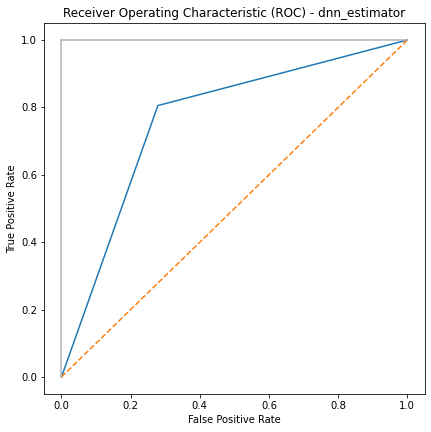

In [8]:
# dnn estimator
estimator = Estimator.dnn_estimator
grid = model_evaluate(estimator, param_grids.get(estimator), **data_dict)

Fitting 2 folds for each of 120 candidates, totalling 240 fits
Estimator                  Accuracy         Recall      Precision       F1 score       F2 score 

xgb_estimator                0.8914         0.2038         0.3016         0.2432         0.2179
Best parameters for xgb_estimator: 
criterion: friedman_mse
loss: log_loss
max_depth: 20
max_features: sqrt
max_leaf_nodes: None
n_estimators: 200
n_iter_no_change: 50
validation_fraction: 0.3


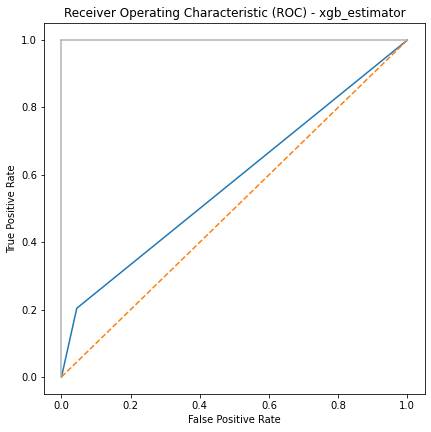

In [9]:
# XGBoost estimator
estimator = Estimator.xgb_estimator
grid = model_evaluate(estimator, param_grids.get(estimator), **data_dict_oversampled)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
Estimator                  Accuracy         Recall      Precision       F1 score       F2 score 

knn_estimator                0.8308         0.3793         0.2187         0.2774         0.3307
Best parameters for knn_estimator: 
n_neighbors: 3


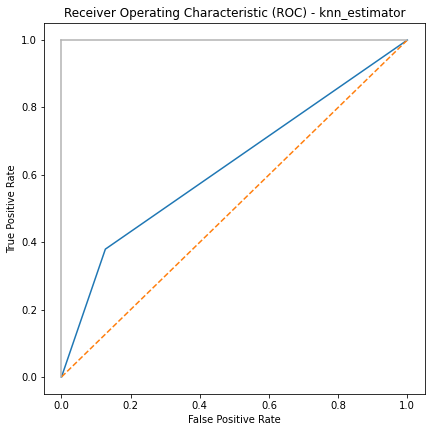

GridSearchCV(cv=2, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [2, 3, 4, 5]}, return_train_score=True,
             scoring=make_scorer(fbeta_score, beta=2), verbose=3)

In [7]:
# knn estimator
estimator = Estimator.knn_estimator
model_evaluate(estimator, param_grids.get(estimator), **data_dict_oversampled)

Fitting 2 folds for each of 60 candidates, totalling 120 fits
Estimator                  Accuracy         Recall      Precision       F1 score       F2 score 

forest_estimator             0.8787         0.3881         0.3254          0.354         0.3737
Best parameters for forest_estimator: 
class_weight: {0: 0.5468029990852277, 1: 5.841538040003653}
max_features: sqrt
max_samples: None
min_samples_split: 10
n_estimators: 100
n_jobs: -1


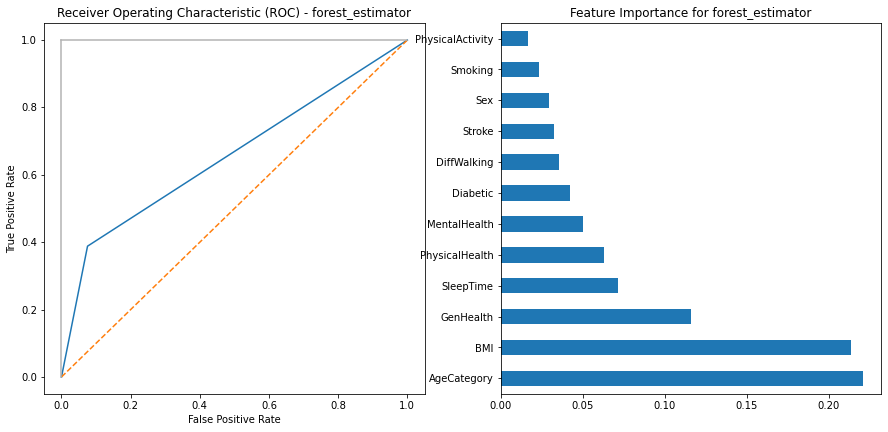

GridSearchCV(cv=2, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 4},
                                          {0: 0.5468029990852277,
                                           1: 5.841538040003653}],
                         'max_features': ['sqrt', 'log2'],
                         'max_samples': [1000, None], 'min_samples_split': [10],
                         'n_estimators': [50, 100, 200, 800, 1000],
                         'n_jobs': [-1]},
             return_train_score=True, scoring=make_scorer(fbeta_score, beta=2),
             verbose=3)

In [10]:
# random forest estimator
estimator = Estimator.forest_estimator
model_evaluate(estimator, param_grids.get(estimator), **data_dict)

Fitting 2 folds for each of 12 candidates, totalling 24 fits
Estimator                  Accuracy         Recall      Precision       F1 score       F2 score 

svc_estimator                0.7365         0.7923         0.2163         0.3398          0.517
Best parameters for svc_estimator: 
class_weight: {0: 0.5468029990852277, 1: 5.841538040003653}
kernel: linear


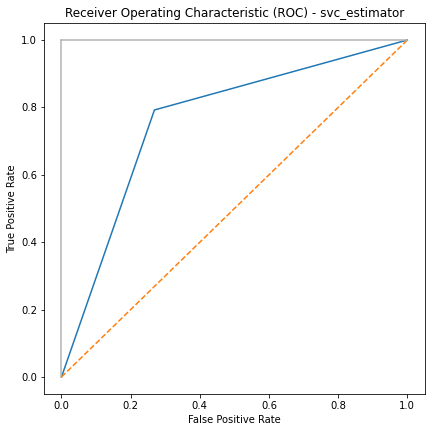

GridSearchCV(cv=2, estimator=SVC(random_state=42), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 4},
                                          {0: 0.5468029990852277,
                                           1: 5.841538040003653}],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             return_train_score=True, scoring=make_scorer(fbeta_score, beta=2),
             verbose=3)

In [11]:
# svc estimator
estimator = Estimator.svc_estimator
model_evaluate(estimator, param_grids.get(estimator), **data_dict)

## Keras plain model

In [ ]:
dropout_rate = 0.4
hidden_layer_sizes = (60,30)
loss = "binary_crossentropy"
metrics= [tf.keras.metrics.Recall()] #["accuracy"] # ["AUC"]# [tf.keras.metrics.Recall()]
class_weight = {0: weight_for_0, 1: weight_for_1}
epochs = 100
batch_size = 1000
optimizer = "adam" #  "adam" "SGD" # also try out 'SGD'
validation_split_fraction = 0.2

model = create_model(dropout_rate=dropout_rate, hidden_layer_sizes=hidden_layer_sizes, activation='relu')
model.compile(optimizer, loss=loss, metrics=metrics)
print(X_train.shape)

history = model.fit(X_train, y_train, epochs=epochs, validation_split=validation_split_fraction, batch_size=batch_size, class_weight=class_weight)

(255836, 22)
Epoch 1/100
205/205 [==============================] - 1s 4ms/step - loss: 0.5523 - recall_6: 0.7391 - val_loss: 0.5061 - val_recall_6: 0.8025
Epoch 2/100
205/205 [==============================] - 1s 3ms/step - loss: 0.5018 - recall_6: 0.8008 - val_loss: 0.5147 - val_recall_6: 0.8196
Epoch 3/100
205/205 [==============================] - 1s 3ms/step - loss: 0.4975 - recall_6: 0.8106 - val_loss: 0.4642 - val_recall_6: 0.7900
Epoch 4/100
205/205 [==============================] - 1s 3ms/step - loss: 0.4957 - recall_6: 0.8111 - val_loss: 0.4915 - val_recall_6: 0.8067
Epoch 5/100
205/205 [==============================] - 1s 3ms/step - loss: 0.4948 - recall_6: 0.8095 - val_loss: 0.5074 - val_recall_6: 0.8240
Epoch 6/100
205/205 [==============================] - 1s 3ms/step - loss: 0.4948 - recall_6: 0.8134 - val_loss: 0.5202 - val_recall_6: 0.8347
Epoch 7/100
205/205 [==============================] - 1s 3ms/step - loss: 0.4937 - recall_6: 0.8105 - val_loss: 0.5031 - val_rec

1999/1999 [==============================] - 1s 569us/step
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 60)                1380      
                                                                 
 dense_16 (Dense)            (None, 30)                1830      
                                                                 
 dropout_5 (Dropout)         (None, 30)                0         
                                                                 
 dense_17 (Dense)            (None, 1)                 31        
                                                                 
Total params: 3,241
Trainable params: 3,241
Non-trainable params: 0
_________________________________________________________________
None
number of ones predicted: 21085
number of zeros predicted: 42874
Estimator                  Accuracy         Recall     

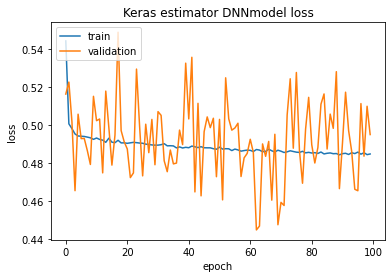

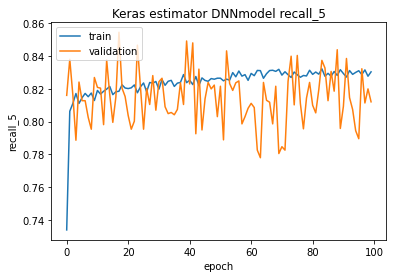

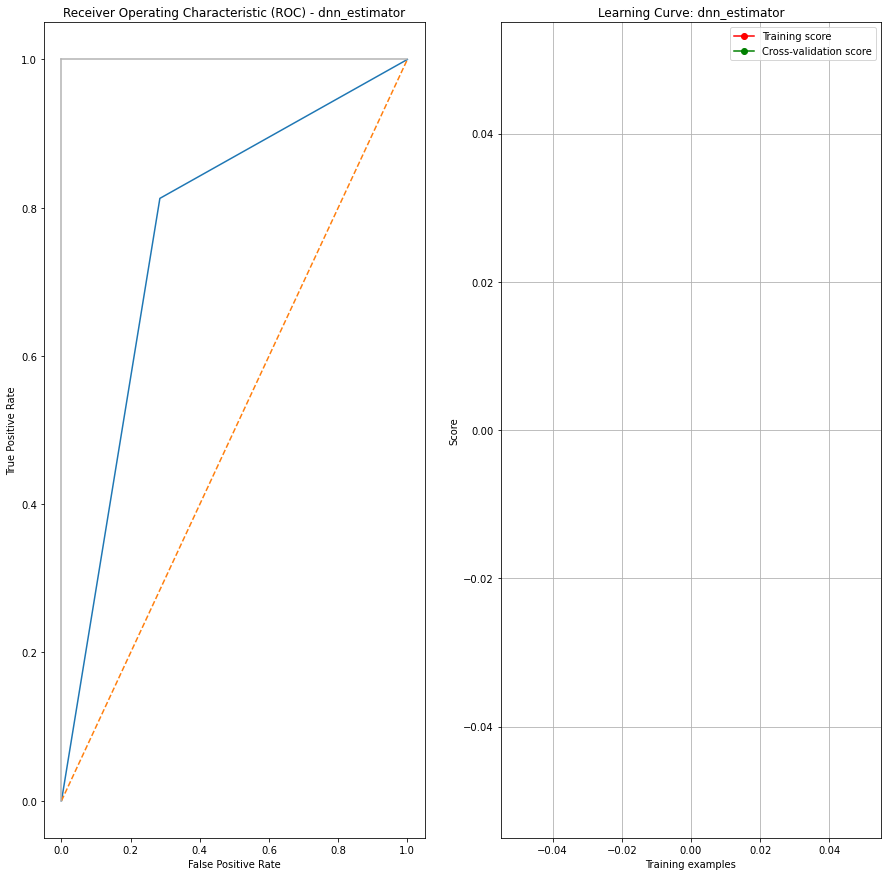

In [22]:
estimator = Estimator.dnn_estimator
estimator_name = "Keras estimator DNN"

y_predicted_probas = model.predict(X_test)

print(model.summary())

y_predicted = (y_predicted_probas > 0.5).astype("int32")

print("number of ones predicted: {}".format(np.count_nonzero(y_predicted == 1)))
print("number of zeros predicted: {}".format(np.count_nonzero(y_predicted == 0)))

print_scores({estimator_name: get_scores(y_test, y_predicted)})

# plot loss and accuracy  
plot_loss(title=estimator_name, history=history)

# plot roc
number_of_rows, number_of_columns = 1, 2
figure_index = 1
figure = plt.figure(figsize=(15, 15))
ax = figure.add_subplot(number_of_rows, number_of_columns, figure_index)
plot_roc(title=estimator.name, ax=ax, y_test=y_test, y_predicted=y_predicted)
figure_index += 1

# plot learning curve in case of nn estimator

ax = figure.add_subplot(number_of_rows, number_of_columns, figure_index)
plot_learning_curve(title=estimator.name, estimator=estimator.value, ax=ax, X=X_train, y=y_train, cv=2)
figure_index += 1

## Logistic Regression

Fitting 2 folds for each of 18 candidates, totalling 36 fits
Estimator                  Accuracy         Recall      Precision       F1 score       F2 score 

log_regr_estimator             0.75         0.7747         0.2232         0.3466         0.5186
Best parameters for log_regr_estimator: 
class_weight: {0: 0.5468029990852277, 1: 5.841538040003653}
max_iter: 200
solver: saga
Coefficient     |value     |
intercept       |-1.507146713472175|
BMI             |   0.87456|
Smoking         |   0.37405|
AlcoholDrinking |  -0.19322|
Stroke          |   1.22307|
PhysicalHealth  |   0.10704|
MentalHealth    |   0.20096|
DiffWalking     |    0.2475|
Sex             |  -0.75175|
AgeCategory     |   3.51086|
Diabetic        |   0.50804|
PhysicalActivity|   0.02587|
GenHealth       |  -2.10228|
SleepTime       |  -0.58482|
Asthma          |   0.30664|
KidneyDisease   |    0.6333|
SkinCancer      |   0.10484|
Race_American Indian/Alaskan Native|   0.17186|
Race_Asian      |  -0.31301|
Race_Black

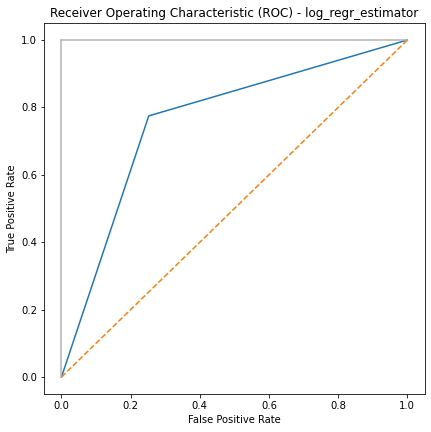

GridSearchCV(cv=2, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 4},
                                          {0: 0.5468029990852277,
                                           1: 5.841538040003653}],
                         'max_iter': [200, 400, 1000],
                         'solver': ['sag', 'saga']},
             return_train_score=True, scoring=make_scorer(fbeta_score, beta=2),
             verbose=3)

In [9]:
# logistic regression estimator
estimator = Estimator.log_regr_estimator
model_evaluate(estimator, param_grids.get(estimator), **data_dict)

In [10]:
iters = 1000
method = "bfgs"
log_regr_model_statsmodels = sm.Logit(y_train,  sm.add_constant(X_train, prepend=False))
log_regr_res_statsmodels = log_regr_model_statsmodels.fit(maxiter=iters, method=method)
print(log_regr_res_statsmodels.summary())

odds_ratios = pd.DataFrame(
    {
        "OR": log_regr_res_statsmodels.params,
        "Lower CI": log_regr_res_statsmodels.conf_int()[0],
        "Upper CI": log_regr_res_statsmodels.conf_int()[1],
    }
)
odds_ratios = np.exp(odds_ratios)
print(odds_ratios)

Optimization terminated successfully.
         Current function value: 0.226868
         Iterations: 154
         Function evaluations: 155
         Gradient evaluations: 155


C:\Users\Equus\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '


                           Logit Regression Results                           
Dep. Variable:           HeartDisease   No. Observations:               255836
Model:                          Logit   Df Residuals:                   255814
Method:                           MLE   Df Model:                           21
Date:                Sat, 03 Dec 2022   Pseudo R-squ.:                  0.2236
Time:                        12:50:25   Log-Likelihood:                -58041.
converged:                       True   LL-Null:                       -74761.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
BMI                                     0.8409        nan        nan        nan         nan         nan
Smoking                                 0.3526        na

In [11]:
print(log_regr_res_statsmodels.summary2())

                               Results: Logit
Model:                  Logit               Pseudo R-squared:    0.224      
Dependent Variable:     HeartDisease        AIC:                 116126.2559
Date:                   2022-12-03 12:50    BIC:                 116356.2063
No. Observations:       255836              Log-Likelihood:      -58041.    
Df Model:               21                  LL-Null:             -74761.    
Df Residuals:           255814              LLR p-value:         0.0000     
Converged:              1.0000              Scale:               1.0000     
----------------------------------------------------------------------------
                                     Coef.  Std.Err.  z  P>|z| [0.025 0.975]
----------------------------------------------------------------------------
BMI                                  0.8409      nan nan   nan    nan    nan
Smoking                              0.3526      nan nan   nan    nan    nan
AlcoholDrinking               

In [12]:
y_pred = log_regr_res_statsmodels.predict(sm.add_constant(X_test, prepend=False))

decision_boundary = 0.1

y_pred.loc[y_pred >= decision_boundary] = 1
y_pred.loc[y_pred < decision_boundary] = 0

from sklearn.metrics import confusion_matrix
tn, fp, fn, tp= confusion_matrix(y_test, y_pred).ravel()

print("tp | {} fn: {}\nfp | {} tn: {}".format(tp, fn, fp, tn))

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

tp | 4012 fn: 1463
fp | 12796 tn: 45688
              precision    recall  f1-score   support

           0       0.97      0.78      0.87     58484
           1       0.24      0.73      0.36      5475

    accuracy                           0.78     63959
   macro avg       0.60      0.76      0.61     63959
weighted avg       0.91      0.78      0.82     63959



**Conclusion**

TODO: Add conclusion

## Final model

After having determined the best model and the best parameters for it in the step of model selection, we now apply this in the following.

In [ ]:
## TODO implement